# Temperature and metallic systems

In this example we consider the modeling of a magnesium lattice
as a simple example for a metallic system.
For our treatment we will use the PBE exchange-correlation functional.
First we import required packages and setup the lattice.
Again notice that DFTK uses the convention that lattice vectors are
specified column by column.

In [1]:
using DFTK
using Plots
using PseudoPotentialData
using Unitful
using UnitfulAtomic

a = 3.01794  # Bohr
b = 5.22722  # Bohr
c = 9.77362  # Bohr
lattice = [[-a -a  0]; [-b  b  0]; [0   0 -c]]

pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
Mg = ElementPsp(:Mg, pseudopotentials)
atoms     = [Mg, Mg]
positions = [[2/3, 1/3, 1/4], [1/3, 2/3, 3/4]];

Next we build the PBE model and discretize it.
Since magnesium is a metal we apply a small smearing
temperature to ease convergence using the Fermi-Dirac
smearing scheme.

In [2]:
kgrid = KgridSpacing(0.9 / u"Å")    # Minimal spacing of k-points,
#                                      in units of wavevectors (inverse Bohrs)
temperature = 0.01                    # Smearing temperature in Hartree
Ecut = 10                             # Kinetic energy cutoff in Hartree
smearing = DFTK.Smearing.FermiDirac() # Smearing method
#                                      also supported: Gaussian,
#                                      MarzariVanderbilt,
#                                      and MethfesselPaxton(order)

model = model_DFT(lattice, atoms, positions;
                  functionals=[:gga_x_pbe, :gga_c_pbe], temperature, smearing)
basis = PlaneWaveBasis(model; Ecut, kgrid);

Note, that in this example both the `Ecut` as well as the minimal $k$-point spacing
`0.9 / u"Å"` far too large to give a converged result. In the online documentation we
have used these small values to obtain a fast execution time.

> **Ecut and kgrid are optional**
>
> Both the `Ecut` and the `kgrid` keyword argument in `PlaneWaveBasis`
> are optional. If the user does not specify these values, DFTK will
> try to determine reasonable default values:
> - Kgrid default:`kgrid=KgridSpacing(2π * 0.022 / u"bohr")`, which
>   usually gives reasonable results for a first calculation.
> - Ecut default: DFTK will consult the [PseudoPotentialData.jl](https://github.com/JuliaMolSim/PseudoPotentialData.jl)
>   library for a recommended kinetic energy cutoff and use the maximal
>   value over all atoms of the calculation.   See the Pseudopotentials
>   chapter for more details on using pseudopotentials with DFTK.
>   For cases where no recommended values can be determined,
>   DFTK will throw an error and expects the user to manually provide
>   a value for `Ecut`.
> Therefore we could also construct a more reasonable basis as follows:

In [3]:
basis_default = PlaneWaveBasis(model)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 2
    num. fft   threads   : 1

    Ecut                 : 42.0 Ha
    fft_size             : (40, 40, 60), 96000 total points
    kgrid                : MonkhorstPack([9, 9, 5])
    num.   red. kpoints  : 405
    num. irred. kpoints  : 36

    Discretized Model(gga_x_pbe+gga_c_pbe, 3D):
        lattice (in Bohr)    : [-3.01794  , -3.01794  , 0         ]
                               [-5.22722  , 5.22722   , 0         ]
                               [0         , 0         , -9.77362  ]
        unit cell volume     : 308.37 Bohr³
    
        atoms                : Mg₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 20
        spin polarization    : none
        temperature          : 0.01 Ha
        smearing             : DFTK.Smearing

As can be seen the default discretisation selects the much finer discretisation
parameters `Ecut=42` and `kgrid=[9, 9, 5]`.

Finally we run the SCF. Two magnesium atoms in
our pseudopotential model result in four valence electrons being explicitly
treated. Nevertheless this SCF will solve for eight bands by default
in order to capture partial occupations beyond the Fermi level due to
the employed smearing scheme. In this example we use a damping of `0.8`.
The default `LdosMixing` should be suitable to converge metallic systems
like the one we model here. For the sake of demonstration we still switch to
Kerker mixing here.

In [4]:
scfres = self_consistent_field(basis, damping=0.8, mixing=KerkerMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -107.0204184893                    0.39    6.2    887ms
  2   -107.6655357572       -0.19       -0.47    3.3    3.41s
  3   -107.6687229604       -2.50       -1.59    3.0    105ms
  4   -107.6687501047       -4.57       -2.77    1.0   70.2ms
  5   -107.6687513538       -5.90       -3.40    4.0    104ms
  6   -107.6687514224       -7.16       -3.93    2.3   83.6ms
  7   -107.6687514267       -8.36       -4.76    3.0   86.4ms
  8   -107.6687514272       -9.36       -5.06    3.7    113ms
  9   -107.6687514272      -10.86       -5.88    1.2    117ms
 10   -107.6687514272      -12.05       -6.71    3.0    511ms


In [5]:
scfres.occupation[1]

17-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 1.9999999999999098
 1.9999272442030191
 1.9121679760337247
 6.511429233300646e-17
 6.510827121519356e-17
 7.050064857820241e-18
 7.377378797272767e-19
 7.376804273228066e-19
 1.7854007566583322e-19

In [6]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             48.3202482
    AtomicLocal         -101.1884683
    AtomicNonlocal      -19.3973010
    Ewald               -53.8605542
    PspCorrection       1.1973309 
    Hartree             30.7290239
    Xc                  -13.4577020
    Entropy             -0.0113289

    total               -107.668751427184

The fact that magnesium is a metal is confirmed
by plotting the density of states around the Fermi level.
To get better plots, we decrease the k spacing a bit for this step,
i.e. we use a finer k-point mesh with more points.

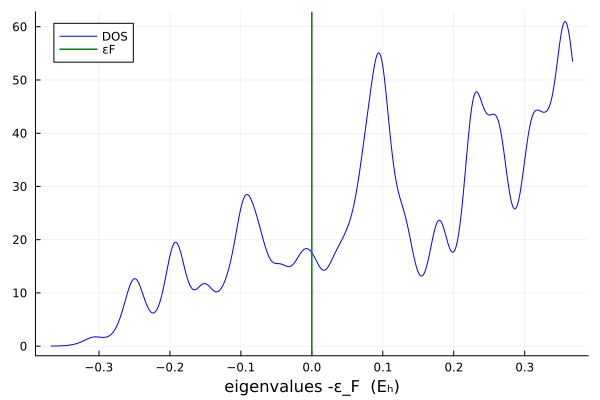

In [7]:
bands = compute_bands(scfres, KgridSpacing(0.7 / u"Å"))
plot_dos(bands)